# Cytopath trajectory analysis

***

Jan T. Schleicher, 2023

Here, we use Cytopath ([Gupta et al. 2022](https://doi.org/10.1016/j.crmeth.2022.100359)) to analyse differentiation trajectories of exhausted CD8 T cells.

In [1]:
# Import required packages
import os

import numpy as np
np.random.seed(0)
import pandas as pd

import scvelo as scv
import scanpy as sc

import cytopath
from scipy import sparse

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

%config Completer.use_jedi = False

In [2]:
DATA_PATH = "../data/"
OUTPUT_PATH = "../output/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [3]:
# Read preprocessed and annotated data
adata = sc.read_h5ad(os.path.join(DATA_PATH, "tex_data_chronic_annotated.h5ad"))
adata

AnnData object with n_obs × n_vars = 13410 × 7170
    obs: 'sampleID', 'barcode', 'sample_type', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'log1p_total_counts_ribosomal', 'pct_counts_ribosomal', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_genes', 'n_counts', 'phase', 'S_score', 'G2M_score', 'score_diff', 'leiden', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'annot'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mitochondrial', 'ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'cell_cycle_genes', 'gene_count_corr', 'means', 'dispersions',

In [4]:
# Run cytopath
if sparse.issparse(adata.X):
    adata.X = adata.X.toarray()

cytopath.sampling(adata, cluster_key="leiden",
                  end_point_probability=0.99,
                  end_clusters=["0", "3"],
                  root_cell_probability=0.99,
                  min_clusters=2,
                  auto_adjust=True,
                  num_cores=os.cpu_count())

Adjusting simulation parameters based on dataset properties. Set auto_adjust=False if this is unwanted.
Number of required simulations per end point (traj_number) set to 826
Number of initial simulations (sim_number) set to 13422


Iterating state probability distributions:   0%|          | 0/200 [00:00<?, ?it/s]

Tolerance reached after 80 iterations of 200.
Number of initial simulation steps (max_steps) set to 80

Sampling round: 0


  0%|          | 0/278 [00:00<?, ?it/s]

Sampling done.


In [5]:
# Infer trajectories
cytopath.trajectories(adata, neighbors_basis="pca", basis="umap",
                      support=0.1,
                      cluster_freq=0.05,
                      fill_cluster=True,
                      num_cores=os.cpu_count())

Calculating hausdorff distances


  0%|          | 0/826 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/2 [00:00<?, ?it/s]

Sample clustering done. Aligning clusters for end point 0
Calculating hausdorff distances


  0%|          | 0/826 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/2 [00:00<?, ?it/s]

Sample clustering done. Aligning clusters for end point 3
Computing neighborhoods of trajectories for end point 0 at each step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing alignment score of cells in trajectory neighborhood w.r.t. trajectories for end point  0


  0%|          | 0/1443 [00:00<?, ?it/s]

Removing cells below cutoff threshold from trajectories for end point  0 (i.e. cells neighborhood)


  0%|          | 0/1 [00:00<?, ?it/s]

Computing neighborhoods of trajectories for end point 3 at each step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing alignment score of cells in trajectory neighborhood w.r.t. trajectories for end point  3


  0%|          | 0/1614 [00:00<?, ?it/s]

Removing cells below cutoff threshold from trajectories for end point  3 (i.e. cells neighborhood)


  0%|          | 0/1 [00:00<?, ?it/s]

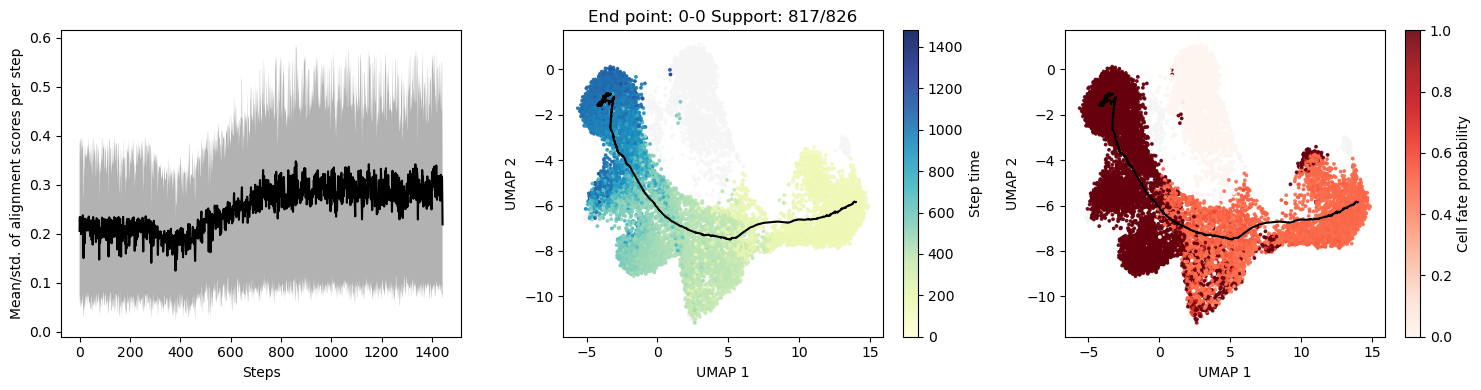

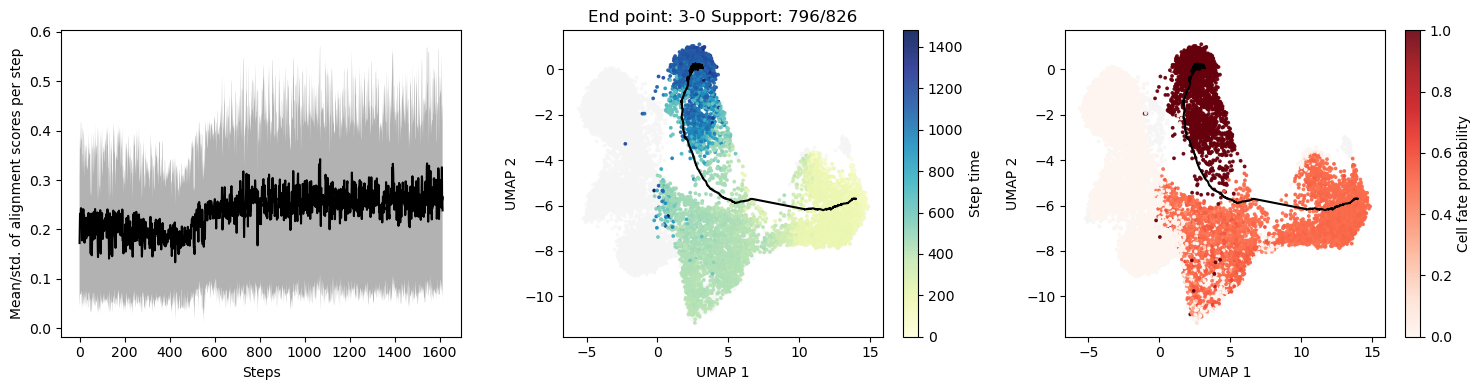

In [6]:
cytopath.plot_trajectories(adata, basis="umap")

In [7]:
# Store cell fate ratios for the two fates
adata.obs["ratio_0"] = adata.uns["trajectories"]["cell_fate_probability"][0]/\
                       (adata.uns["trajectories"]["cell_fate_probability"][1] + adata.uns["trajectories"]["cell_fate_probability"][0])
adata.obs["ratio_0"] = adata.obs["ratio_0"].replace(np.inf, np.nan)

adata.obs["ratio_1"] = adata.uns["trajectories"]["cell_fate_probability"][1]/\
                       (adata.uns["trajectories"]["cell_fate_probability"][1] + adata.uns["trajectories"]["cell_fate_probability"][0])
adata.obs["ratio_1"] = adata.obs["ratio_1"].replace(np.inf, np.nan)

adata.obs["pst"] = pd.DataFrame(adata.uns["trajectories"]["step_time"]).mean(0).values

In [8]:
# Save results
adata.write_h5ad(os.path.join(DATA_PATH, "tex_data_chronic_cytopath.h5ad"))